In [7]:
import signac as sg
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib
from scipy.special import gamma
from scipy.optimize import curve_fit
from ipywidgets import interact
import ipywidgets as widgets

In [8]:
project = sg.get_project()

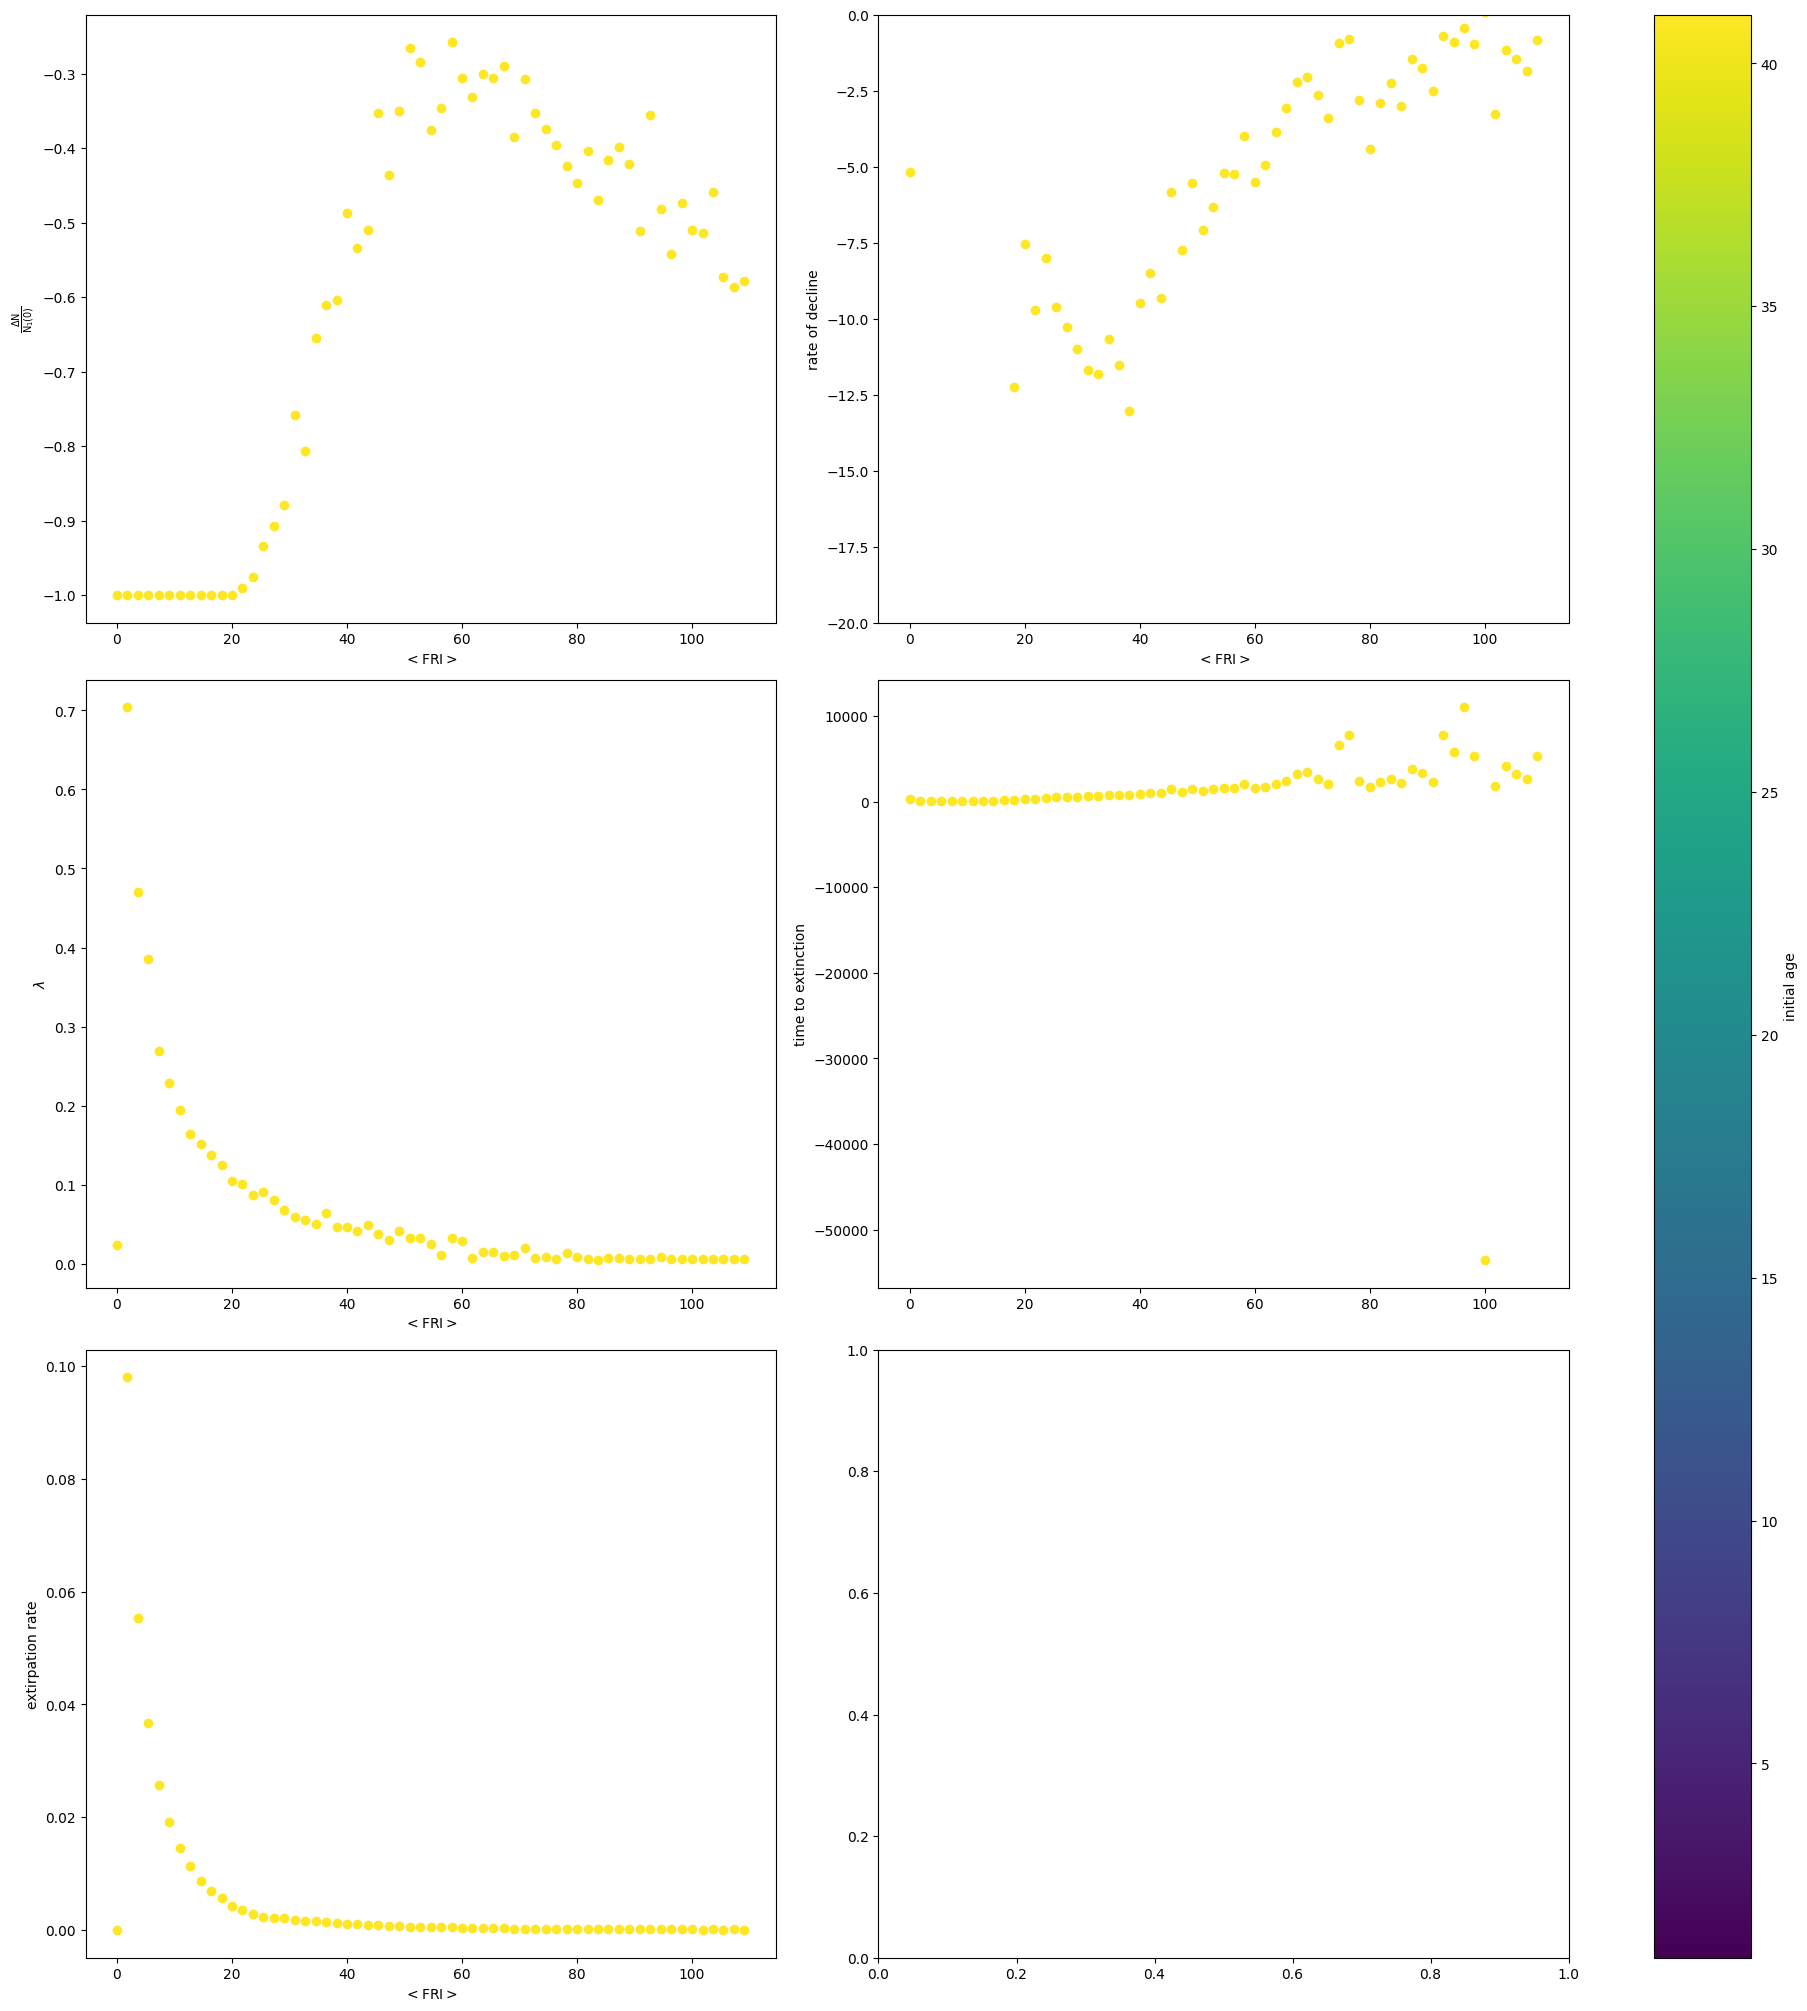

In [133]:
metrics = ['fri', 'lambda', 'extirpation_rate', 'rate_of_decline']
# metrics = ['fri']
fig, axs = plt.subplots(3, 2, figsize=(9*2,len(metrics)*5), layout='constrained')
c = 1.42
init_age_vec = sorted(list(list(project.detect_schema()['init_age'].items())[0][1]))
minima = min(init_age_vec)
maxima = max(init_age_vec)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
for plot_i, metric in enumerate(metrics):
    if plot_i >= 3:
        col = 1
    else:
        col = 0
    row = plot_i - 3*col
    for init_age in init_age_vec[-1:]:
    # for init_age in init_age_vec:
        color = mapper.to_rgba(init_age)
        for job in project.find_jobs({'init_age': init_age}):
            with job.data as data:
                census_t = np.array(data['census_t'])
                N_tot_vec = np.array(data['N_tot_vec'])
                N_tot_mean = N_tot_vec.mean(axis=0)
                max_i = np.nonzero(N_tot_mean == max(N_tot_mean))[0][0]
                fri = job.sp.weibull_b * gamma(1+1/c)
                x = fri
                if metric == 'fri':
                    final_approx_vec = np.mean(N_tot_vec[:,-20:], axis=1)
                    init = N_tot_vec[0,0]
                    err = np.std(final_approx_vec/init, ddof=1)
                    diff_vec = final_approx_vec - init
                    y_vec = diff_vec / init
                    y = np.mean(y_vec)
                    err = np.std(y_vec, ddof=1)
                if metric == 'lambda':
                    def exp(x, a, b):
                        return a * np.exp(-b * x)
                    popt, pcov = curve_fit(exp, census_t[max_i:], N_tot_mean[max_i:], 
                                           x_scale=[1000,0.01], method='trf', bounds=([100, 0], [8000000., 1.]))
                    if np.linalg.cond(pcov) == np.inf:
                        popt[1] = 0
                    y = popt[1]
                if metric == 'extirpation_rate':
                    frac_extirpated = np.array([sum(N_tot_vec[:,t_i]==0)/N_tot_vec.shape[0] for t_i in range(N_tot_vec.shape[1])])
                    # Set a threshold for the max extirpation fraction before we stop fitting a line
                    extir_thresh = 0.95
                    if np.any(frac_extirpated >= extir_thresh):
                        max_extir_i = min(np.nonzero(frac_extirpated >= extir_thresh)[0])
                    else:
                        max_extir_i = N_tot_vec.shape[1]
                    def line(x, m):
                        return m*x
                    popt, pcov = curve_fit(line, census_t[max_i:max_extir_i], frac_extirpated[max_i:max_extir_i])
                    y = popt[0]
                if metric == 'rate_of_decline':
                    def exp(x, a, b, c):
                        return a * np.exp(-b * x) + c
                    popt, pcov = curve_fit(exp, census_t[max_i:], N_tot_mean[max_i:], x_scale=[1000,0.01,1000], method='trf', bounds=([10_000, 0, 2_000], [600000., 1., 600000]))
                    acc = popt[1]**2 * popt[0] * np.exp(-popt[1]*census_t[max_i:])
                    thresh = 0.15
                    burn_in_end_i = min(np.nonzero(acc < thresh)[0]) + max_i
                    def line(x, m, b):
                        return m*x + b
                    final_i = 500
                    too_low = np.nonzero(N_tot_mean[:final_i] < 50)[0]
                    if len(too_low) > 0:
                        # Only adjust the starting point for the linear fit if interval is too small
                        if min(too_low) - burn_in_end_i < 100:
                            adjustment = final_i - min(too_low)
                            if (burn_in_end_i - adjustment) < max_i:
                                burn_in_end_i = max_i
                            else:
                                burn_in_end_i -= adjustment
                        # Set the final point of the interval where pop avg drops below threshold
                        final_i = min(too_low)
                    popt, pcov = curve_fit(line, census_t[burn_in_end_i:final_i], N_tot_mean[burn_in_end_i:final_i])
                    y = popt[0]
                # axs[plot_i].scatter(x, y, color=color)
                axs[row][col].scatter(x, y, color=color)
                if metric == 'rate_of_decline':
                    # Also get predicted time to extinction from this
                    y = -popt[1]/popt[0]
                    axs[row+1][col].scatter(x, y, color=color)
                # axs.errorbar(fri, y, yerr=err, color=color, fmt='o')
    if plot_i == 0:
        plt.colorbar(mapper, ax=axs, label='initial age')
    if metric == 'fri':
        axs[row][col].set_ylabel(r'$\frac{\Delta \text{N}}{\text{N}_1(0)}$')
    if metric == 'lambda':
        axs[row][col].set_ylabel(r'$\lambda$')
    if metric == 'extirpation_rate':
        axs[row][col].set_ylabel('extirpation rate')
    if metric == 'rate_of_decline':
        axs[row][col].set_ylabel('rate of decline')
        axs[row][col].set_ylim(-20,0)
        axs[row+1][col].set_ylabel('time to extinction')
        # axs[row+1][col].set_ylim(0,10_000)
    axs[row][col].set_xlabel(r'$<\text{FRI}>$')
fig.savefig('metric_sensitivity.png', dpi=400)

In [194]:
N_tot_vec = np.load('N_tot_vec.npy')
N_tot_mean = N_tot_vec.mean(axis=0)
census_t = np.load('census_t.npy')
delta_t = census_t[1] - census_t[0]

In [33]:
for job in project.find_jobs({'weibull_b': 18, 'init_age': 41}):
    with job.data as data:
        N_tot_vec = np.array(data['N_tot_vec'])
        final_approx_vec = np.mean(N_tot_vec[:,-20:], axis=1)
        y_vec = final_approx_vec
        census_t = np.array(data['census_t'])
        N_tot_mean = N_tot_vec.mean(axis=0)

### Interactive

In [130]:
def exp_fit_interactive(weibull_b, init_age):
    for job in project.find_jobs({'weibull_b': weibull_b, 'init_age': init_age}):
        with job.data as data:
            N_tot_vec = np.array(data['N_tot_vec'])
            final_approx_vec = np.mean(N_tot_vec[:,-20:], axis=1)
            y_vec = final_approx_vec
            census_t = np.array(data['census_t'])
            N_tot_mean = N_tot_vec.mean(axis=0)

    # Replica averaged lambda
    max_i = np.nonzero(N_tot_mean == max(N_tot_mean))[0][0]
    # max_i = 40

    def exp(x, a, b):
        return a * np.exp(-b * x)
    popt, pcov = curve_fit(exp, census_t[max_i:], N_tot_mean[max_i:], x_scale=[1000,0.01], method='trf', bounds=([100, 0], [8000000., 1.]))
    # print(popt)
    # print(np.linalg.cond(pcov))
    # print(np.linalg.cond(pcov) == np.inf)
    plt.plot(census_t, N_tot_mean, c='k')
    K_adult = 16000
    plt.axhline(K_adult, ls='--', c='k', alpha=0.35)
    plt.axvline(census_t[max_i], ls='--', c='k')
    plt.axhline(0, c='k', alpha=0.5)
    plt.plot(census_t[max_i:], exp(census_t[max_i:], popt[0], popt[1]), 
             label=r'$\lambda={}$'.format(np.round(popt[1], 4)))
    def exp(x, a, b, c):
        return a * np.exp(-b * x) + c
    popt, pcov = curve_fit(exp, census_t[max_i:], N_tot_mean[max_i:], x_scale=[1000,0.01,1000], method='trf')#, bounds=([10_000, 0, 2_000], [600000., 1., 600000]))
    acc = popt[1]**2 * popt[0] * np.exp(-popt[1]*census_t[max_i:])
    thresh = 0.15
    burn_in_end_i = min(np.nonzero(acc < thresh)[0]) + max_i
    plt.axvline(census_t[burn_in_end_i], c='red', alpha=0.5, ls='--')
    def line(x, m, b):
        return m*x + b
    final_i = 500
    too_low_thresh = 50
    too_low = np.nonzero(N_tot_mean[:final_i] < too_low_thresh)[0]
    if len(too_low) > 0:
        # Only adjust the starting point for the linear fit if interval is too small
        if min(too_low) - burn_in_end_i < 100:
            adjustment = final_i - min(too_low)
            if (burn_in_end_i - adjustment) < max_i:
                burn_in_end_i = max_i
            else:
                burn_in_end_i -= adjustment
        # Set the final point of the interval where pop avg drops below threshold
        final_i = min(too_low)
    plt.axvline(burn_in_end_i, c='purple', ls=':')
    plt.axvline(final_i, c='purple', ls=':')
    x = census_t[burn_in_end_i:final_i]
    y = N_tot_mean[burn_in_end_i:final_i]
    popt, pcov = curve_fit(line, x, y)
    plt.plot(x, line(x, *popt), label='{}x+{}'.format(np.round(popt[0], 4), np.round(popt[1], 4)))
    print(-popt[1]/popt[0])
    # plt.ylim(0,12_000)
    plt.ylim(0,14_000)
    plt.axhline(too_low_thresh)
    plt.legend()
    plt.show()
    
    # Fraction extirpated over time
    frac_extirpated = np.array([sum(N_tot_vec[:,t_i]==0)/N_tot_vec.shape[0] for t_i in range(N_tot_vec.shape[1])])
    # Set a threshold for the max extirpation fraction before we stop fitting a line
    extir_thresh = 0.95
    if np.any(frac_extirpated >= extir_thresh):
        max_extir_i = min(np.nonzero(frac_extirpated >= extir_thresh)[0])
    else:
        max_extir_i = N_tot_vec.shape[1]
    def line(x, m):
        return m*x
    popt, pcov = curve_fit(line, census_t[max_i:max_extir_i], frac_extirpated[max_i:max_extir_i])
    # print(popt)
    # print(np.linalg.cond(pcov))
    plt.plot(census_t, frac_extirpated, c='k')
    plt.plot(census_t[max_i:max_extir_i], line(census_t[max_i:max_extir_i], popt[0]), label='rate={}'.format(np.round(popt[0], 6)))
    plt.legend()
    plt.show()
    
    # # Try testing for normality to find end of burn in period
    # from scipy.stats import normaltest
    # delta_t = census_t[1]-census_t[0]
    # mort = [(N_tot_mean[i+1] - N_tot_mean[i])/delta_t for i in range(len(N_tot_mean)-1)]
    # pvals = [normaltest(mort[i:])[1] for i in range(len(mort)-20)]
    # plt.plot(pvals)
    # plt.axhline(0.05, ls='--')
interact(exp_fit_interactive,
         weibull_b = widgets.IntSlider(value=24, min=0, max=76, step=2),
         init_age = widgets.IntSlider(value=41, min=1, max=41, step=8))

interactive(children=(IntSlider(value=24, description='weibull_b', max=76, step=2), IntSlider(value=41, descri…

<function __main__.exp_fit_interactive(weibull_b, init_age)>

(-480.0, 24000.0)

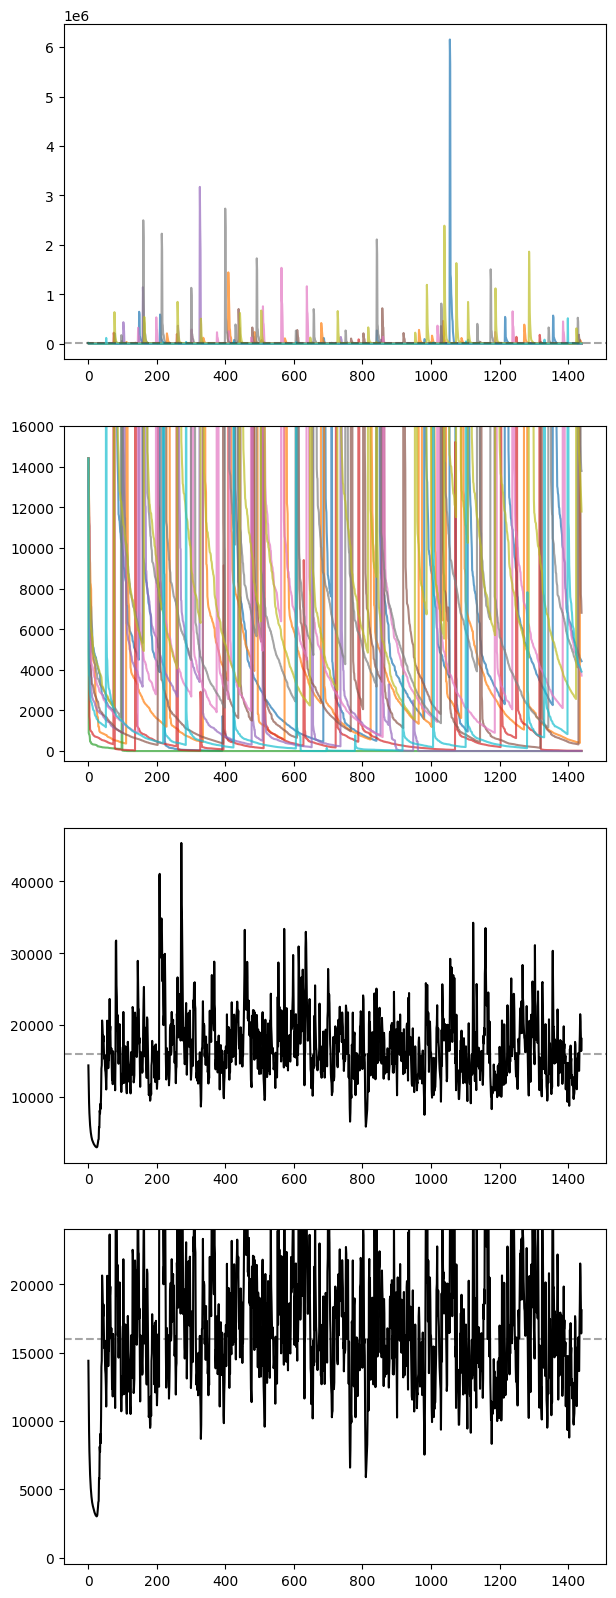

In [77]:
fig, axs = plt.subplots(4, 1, figsize=(7,20))
for N in N_tot_vec[::int(len(N_tot_vec)/10)]:
    axs[0].plot(census_t,N, alpha=0.7)
    axs[1].plot(census_t,N, alpha=0.7)
K_adult = 16000
axs[0].axhline(K_adult, ls='--', c='k', alpha=0.35)
axs[1].set_ylim(-0.03*K_adult,K_adult)
#print(len(model.N_tot_vec.mean(axis=0)))
axs[2].plot(census_t, N_tot_vec.mean(axis=0), c='k')
axs[2].axhline(K_adult, ls='--', c='k', alpha=0.35)
axs[3].plot(census_t, N_tot_vec.mean(axis=0), c='k')
axs[3].axhline(K_adult, ls='--', c='k', alpha=0.35)
axs[3].set_ylim(-0.03*K_adult,1.5*K_adult)